In [58]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter

In [ ]:

def plot_video_npz_folder(
    folder,
    smooth=True,
    smooth_window=9,
    smooth_poly=3,
    normalize_time=False,     # 是否將時間軸正規化到 0-1
    normalize_channel=False   # 是否將每個 channel 正規化到 0-1
):
    """
    讀取資料夾下多個 npz 檔 (每個為 T×C)，
    保留各影片原始長度，並計算平均線：
      - 前五名平均線（深紅）
      - 後面平均線（深藍）
    平均線會延伸到最長影片，缺失值自動忽略。
    可選：
      - normalize_time: 是否將時間軸拉到 0-1
      - normalize_channel: 是否將每個 channel 數值正規化到 0-1
    """
    files = sorted([
        f for f in os.listdir(folder)
        if f.endswith(".npz") and not f.endswith("_meta.npz")
    ])
    if not files:
        print("[Warning] 沒有找到任何 npz 檔。")
        return

    # 載入影片
    data_list = []
    mean_values = []
    for fname in files:
        data = np.load(os.path.join(folder, fname))["data"]
        if normalize_channel:
            # 將每個 channel 正規化到 0-1
            min_val = np.min(data, axis=0)
            max_val = np.max(data, axis=0)
            data = (data - min_val) / (max_val - min_val + 1e-8)
        data_list.append(data)
        mean_values.append(data.mean())

    # 依平均值排序
    sorted_indices = np.argsort(mean_values)[::-1]
    sorted_files = [files[i] for i in sorted_indices]
    sorted_data = [data_list[i] for i in sorted_indices]

    n_files = len(sorted_files)
    n_red = min(5, n_files)
    n_blue = max(0, n_files - n_red)
    red_colors = plt.cm.Reds(np.linspace(0.5, 0.9, n_red))
    blue_colors = plt.cm.Blues(np.linspace(0.5, 0.9, n_blue))
    colors = np.vstack([red_colors, blue_colors])

    C = sorted_data[0].shape[1]
    fig, axes = plt.subplots(C, 1, figsize=(10, 3*C), sharex=False)
    if C == 1:
        axes = [axes]

    red_group = []
    blue_group = []

    # 畫單影片
    for i, (fname, data) in enumerate(zip(sorted_files, sorted_data)):
        color = colors[i] if i < len(colors) else (0.5,0.5,0.5,1)
        for c in range(C):
            y = data[:, c]
            if smooth and len(y) > smooth_window:
                y = savgol_filter(y, window_length=smooth_window, polyorder=smooth_poly)
            x = np.linspace(0, 1, len(y)) if normalize_time else np.arange(len(y))
            axes[c].plot(x, y, color=color, alpha=0.35, linewidth=1)
        if i < n_red:
            red_group.append(data)
        else:
            blue_group.append(data)

    # 平均線（延伸到最長影片）
    def compute_avg_line(group, c):
        if not group:
            return None, None
        max_len = max(d.shape[0] for d in group)
        avg_line = np.zeros(max_len)
        count = np.zeros(max_len)
        for d in group:
            L = d.shape[0]
            avg_line[:L] += d[:, c]
            count[:L] += 1
        avg_line = avg_line / count
        if smooth and len(avg_line) > smooth_window:
            avg_line = savgol_filter(avg_line, window_length=smooth_window, polyorder=smooth_poly)
        x = np.linspace(0, 1, max_len) if normalize_time else np.arange(max_len)
        return x, avg_line

    # 畫平均線
    for c in range(C):
        x_red, red_avg = compute_avg_line(red_group, c)
        if red_avg is not None:
            axes[c].plot(x_red, red_avg, color="darkred", linewidth=3, label="Top 5 Avg")
        x_blue, blue_avg = compute_avg_line(blue_group, c)
        if blue_avg is not None:
            axes[c].plot(x_blue, blue_avg, color="navy", linewidth=3, label="Rest Avg")

    # 美化
    channel_names = ["depth_max", "depth_q3", "depth_mean", "depth_q1", "depth_min","seg_human_ratio", "seg_nature_ratio",]
    for c in range(C):
        axes[c].set_title(channel_names[c])
        axes[c].set_ylabel("Value")
        axes[c].legend(fontsize=8, loc='upper right', frameon=False)
    axes[-1].set_xlabel("Normalized Time" if normalize_time else "Frame Index")
    plt.tight_layout()
    plt.show()


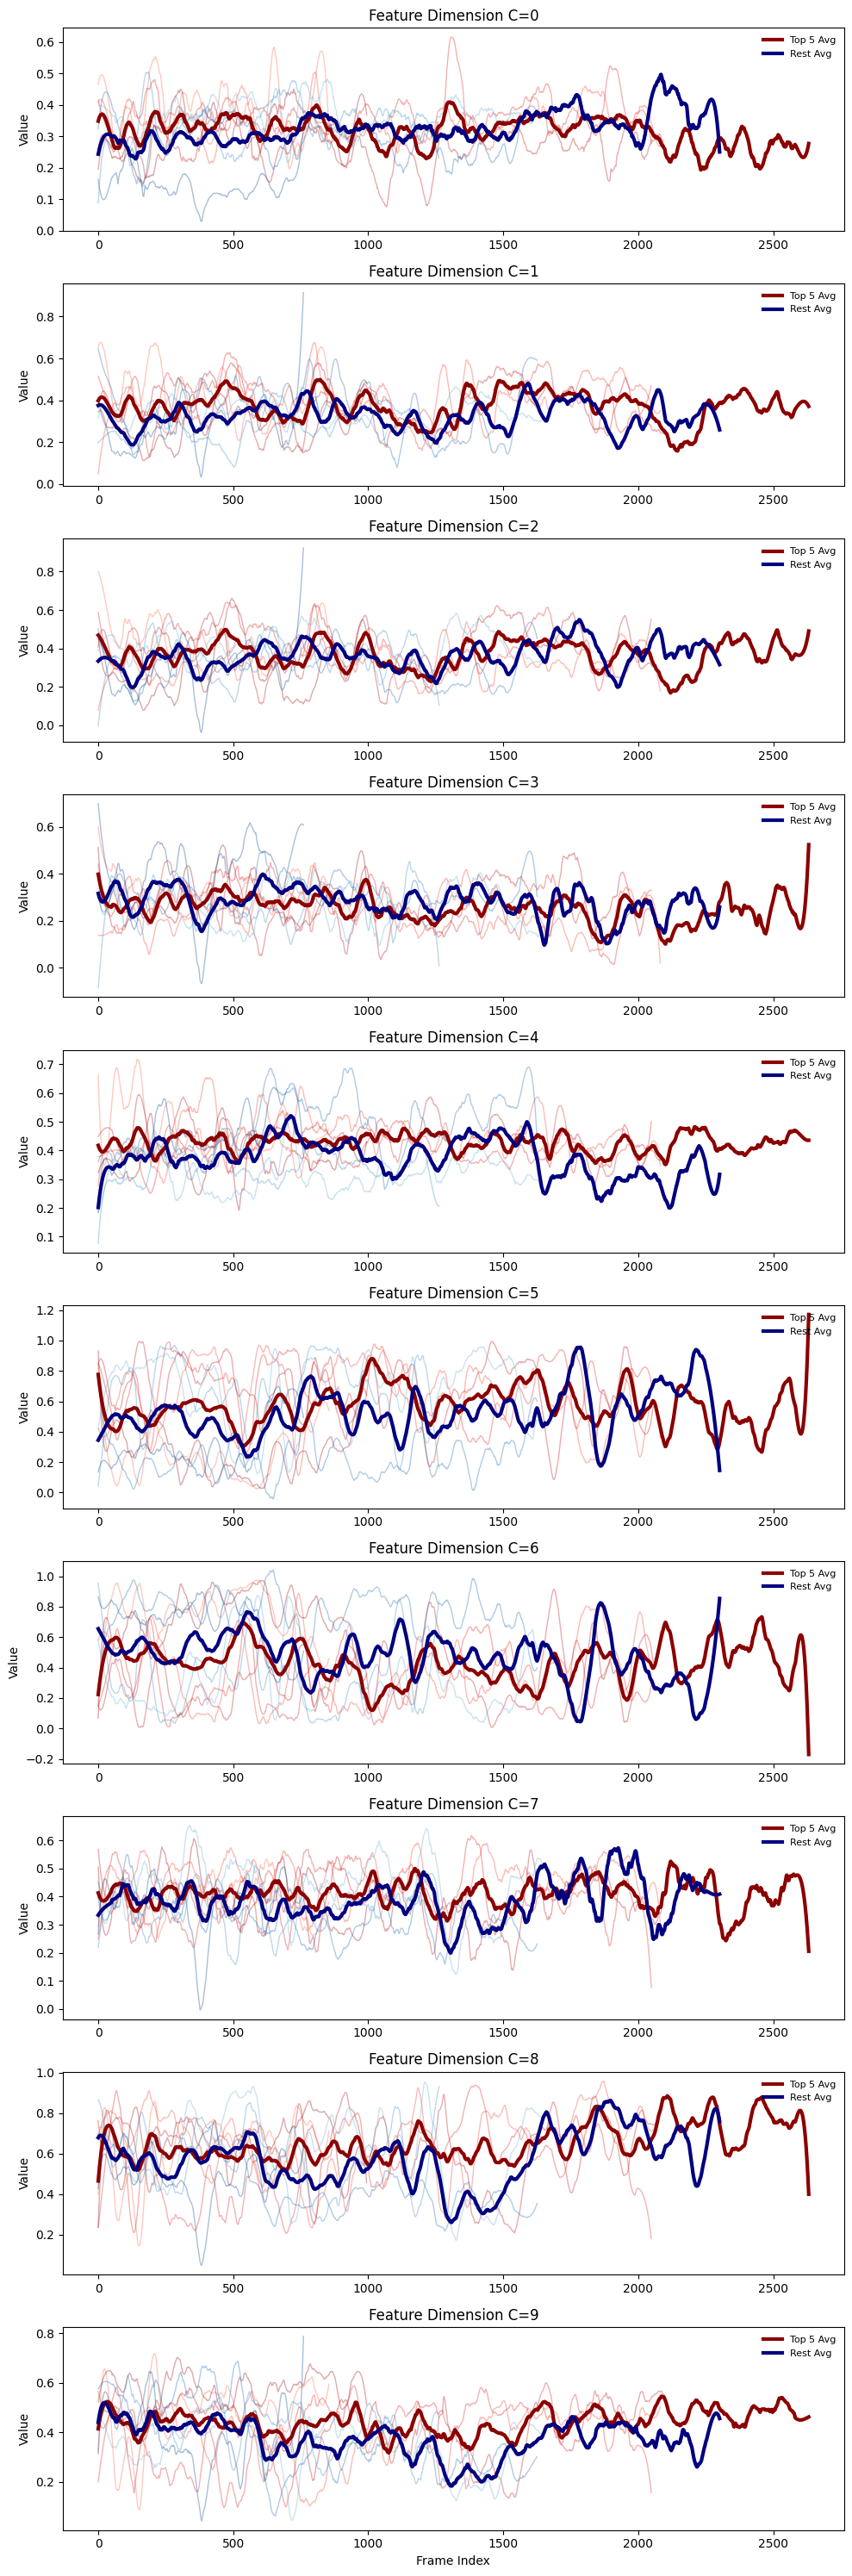

In [60]:
# 使用範例
npz_path = r"C:\Users\yutse\OneDrive\桌面\cg\dataset_video\npz_raw"
plot_video_npz_folder(npz_path, smooth_window=100, normalize_time=False , normalize_channel=True)
